# ML Models for Predicting Band-Gaps of Semiconductors

Semiconductors have very important industrial applications in e.g. electron transistors, photon detectors, solar cells, and so on. To develop these devices with high performance, an important physical quantity, which is called the band gap, needs to be carefully designed because it determines fundamentally the electrical and optical properties of a semicondutor. Machine learning approach can be employed to perform this design by predicting the band gaps of semiconductors.

We will build machine learning models for predicting the band gaps of semiconductors from materials databases using `scikit-learn` and `streamlit`. 

**STEP 0: Load (and Clean) Data**

To load our data, we will use `matminer`. This package interfaces with a lot of leading materials databases including `Materials Project`, `Citrine`, `AFLOW`, `Materials Data Facility`, and `Materials Platform for Data Science`. It currently provides a repository of more than 40 datasets (still growing) which come from published and peer-reviewed machine-learning and high-throughput studies of different materials properties.

In [123]:
from matminer.datasets import get_available_datasets
print("The number of available datasets:", len(get_available_datasets(print_format=None)))

The number of available datasets: 42


Here we will download the `dielectric_constant` dataset.

In [124]:
# Tell matminer to download dataset to ./data
%env MATMINER_DATA data 
    
import os

name = "dielectric_constant"
if os.path.isfile(os.path.join("data", f"{name}.json.gz")):
    from matminer.utils.io import load_dataframe_from_json
    df = load_dataframe_from_json(os.path.join("data", f"{name}.json.gz"))
else:
    from matminer.datasets import load_dataset
    df = load_dataset(name)

env: MATMINER_DATA=data


Reading file data/dielectric_constant.json.gz: 1056it [03:54,  4.50it/s]                                               | 1/1056 [00:00<02:48,  6.26it/s]
Decoding objects from data/dielectric_constant.json.gz: 100%|#######################################################| 1056/1056 [03:54<00:00,  4.50it/s]
Decoding objects from data/dielectric_constant.json.gz:  60%|#################################                      | 635/1056 [00:00<00:00, 918.73it/s]

Now we inspect the dataset to see if there are any nulls, duplicates, and anamalies in the data.

In [125]:
df.head()

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...


In [126]:
print("Checking the shape of the dataset...")
print(df.shape)
print("Checking if there are null values...")
print(df.isnull().sum())
print("Checking if there are any duplicates...")
print(len(df["material_id"]) != len(df["material_id"].unique()))
print("Checking if there are data anomalies...")
df.describe()

Checking the shape of the dataset...
(1056, 16)
Checking if there are null values...
material_id          0
formula              0
nsites               0
space_group          0
volume               0
structure            0
band_gap             0
e_electronic         0
e_total              0
n                    0
poly_electronic      0
poly_total           0
pot_ferroelectric    0
cif                  0
meta                 0
poscar               0
dtype: int64
Checking if there are any duplicates...
False
Checking if there are data anomalies...


,nsites,space_group,volume,band_gap,n,poly_electronic,poly_total
count,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000
mean,7.530303,142.970644,166.420376,2.119432,2.434886,7.248049,14.777898
std,3.388443,67.264591,97.425084,1.604924,1.148849,13.054947,19.435303
min,2.000000,1.000000,13.980548,0.110000,1.280000,1.630000,2.080000
25%,5.000000,82.000000,96.262337,0.890000,1.770000,3.130000,7.557500
50%,8.000000,163.000000,145.944691,1.730000,2.190000,4.790000,10.540000
75%,9.000000,194.000000,212.106405,2.885000,2.730000,7.440000,15.482500
max,20.000000,229.000000,597.341134,8.320000,16.030000,256.840000,277.780000


**STEP 1: Pre-process Data**

In [127]:
# Filter out semiconductors
mask = df["band_gap"] > 0
df = df[mask]
df.head()

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...


In [128]:
df = df[["formula", "nsites", "volume", "structure", "poly_electronic", "poly_total", "band_gap"]]
df.head()

,formula,nsites,volume,structure,poly_electronic,poly_total,band_gap
0,Rb2Te,3,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",3.44,6.23,1.88
1,CdCl2,3,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.16,6.73,3.52
2,MnI2,3,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",4.97,10.64,1.17
3,LaN,4,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,7.04,17.99,1.12
4,MnF2,6,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.35,7.12,2.87


Decoding objects from data/dielectric_constant.json.gz: 100%|######################################################| 1056/1056 [00:11<00:00, 918.73it/s]

In [129]:
df["poly_ionic"] = df["poly_total"] - df["poly_electronic"]
df.head()

,formula,nsites,volume,structure,poly_electronic,poly_total,band_gap,poly_ionic
0,Rb2Te,3,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",3.44,6.23,1.88,2.79
1,CdCl2,3,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.16,6.73,3.52,3.57
2,MnI2,3,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",4.97,10.64,1.17,5.67
3,LaN,4,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,7.04,17.99,1.12,10.95
4,MnF2,6,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.35,7.12,2.87,4.77


In [130]:
# featurize structure

from matminer.featurizers.structure import DensityFeatures

densityfeatures = DensityFeatures()
df = densityfeatures.featurize_dataframe(df, "structure")
df.head()


DensityFeatures: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:00<00:00, 1653.17it/s]


,formula,nsites,volume,structure,poly_electronic,poly_total,band_gap,poly_ionic,density,vpa,packing fraction
0,Rb2Te,3,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",3.44,6.23,1.88,2.79,3.108002,53.167069,0.753707
1,CdCl2,3,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.16,6.73,3.52,3.57,3.611055,28.099366,0.284421
2,MnI2,3,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",4.97,10.64,1.17,5.67,4.732379,36.111958,0.318289
3,LaN,4,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,7.04,17.99,1.12,10.95,5.760192,22.040641,0.730689
4,MnF2,6,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.35,7.12,2.87,4.77,3.726395,13.804400,0.302832


In [131]:
# featurize formula

from matminer.featurizers.conversions import StrToComposition

stc = StrToComposition()
df = stc.featurize_dataframe(df, "formula", pbar=False)
df.head()

,formula,nsites,volume,structure,poly_electronic,poly_total,band_gap,poly_ionic,density,vpa,packing fraction,composition
0,Rb2Te,3,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",3.44,6.23,1.88,2.79,3.108002,53.167069,0.753707,"(Rb, Te)"
1,CdCl2,3,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.16,6.73,3.52,3.57,3.611055,28.099366,0.284421,"(Cd, Cl)"
2,MnI2,3,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",4.97,10.64,1.17,5.67,4.732379,36.111958,0.318289,"(Mn, I)"
3,LaN,4,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,7.04,17.99,1.12,10.95,5.760192,22.040641,0.730689,"(La, N)"
4,MnF2,6,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.35,7.12,2.87,4.77,3.726395,13.804400,0.302832,"(Mn, F)"


In [132]:
# featurize composition

from matminer.featurizers.composition.element import ElementFraction

ef = ElementFraction()
df = ef.featurize_dataframe(df, "composition")
df.head()


ElementFraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:00<00:00, 8956.03it/s]


,formula,nsites,volume,structure,poly_electronic,poly_total,band_gap,poly_ionic,density,vpa,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,Rb2Te,3,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",3.44,6.23,1.88,2.79,3.108002,53.167069,...,0,0,0,0,0,0,0,0,0,0
1,CdCl2,3,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.16,6.73,3.52,3.57,3.611055,28.099366,...,0,0,0,0,0,0,0,0,0,0
2,MnI2,3,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",4.97,10.64,1.17,5.67,4.732379,36.111958,...,0,0,0,0,0,0,0,0,0,0
3,LaN,4,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,7.04,17.99,1.12,10.95,5.760192,22.040641,...,0,0,0,0,0,0,0,0,0,0
4,MnF2,6,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.35,7.12,2.87,4.77,3.726395,13.804400,...,0,0,0,0,0,0,0,0,0,0


In [133]:
#exclude = ["formula", "nsites", "volume", "structure", "poly_total", "poly_electronic", "poly_ionic", "composition"]
exclude = ["formula", "structure", "composition"]
df_train = df.drop(exclude, axis=1)
df_train.head()

,nsites,volume,poly_electronic,poly_total,band_gap,poly_ionic,density,vpa,packing fraction,H,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,3,159.501208,3.44,6.23,1.88,2.79,3.108002,53.167069,0.753707,0.0,...,0,0,0,0,0,0,0,0,0,0
1,3,84.298097,3.16,6.73,3.52,3.57,3.611055,28.099366,0.284421,0.0,...,0,0,0,0,0,0,0,0,0,0
2,3,108.335875,4.97,10.64,1.17,5.67,4.732379,36.111958,0.318289,0.0,...,0,0,0,0,0,0,0,0,0,0
3,4,88.162562,7.04,17.99,1.12,10.95,5.760192,22.040641,0.730689,0.0,...,0,0,0,0,0,0,0,0,0,0
4,6,82.826401,2.35,7.12,2.87,4.77,3.726395,13.804400,0.302832,0.0,...,0,0,0,0,0,0,0,0,0,0


**STEP 2: Prepare Training X/Y**

In [135]:
# Prepare X/Y 
X = df_train.drop(["band_gap"], axis=1)
Y = df_train["band_gap"].values

# Split into train/test sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

print(X_train.shape, Y_train.shape)
print(X_test.shape, X_test.shape)

(950, 111) (950,)
(106, 111) (106, 111)


**STEP 3: Build/Train/Evaluate Models**

In [136]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

models = []
models.append(("LinearRegression", LinearRegression()))
models.append(("DecisionTreeRegressor", DecisionTreeRegressor()))
models.append(("RandomForestRegressor", RandomForestRegressor(random_state=1)))

for name, model in models:
    
    print("----------------------------------")
    model.fit(X_train, Y_train)
    print(f"Evaluate {name} Model")
    R2 = round(model.score(X_test, Y_test), 3)
    RMSE = np.sqrt(mean_squared_error(y_true=Y_test, y_pred=model.predict(X_test))).round(decimals=3)
    print(f"Testing R2 = {R2}")
    print(f"Testing RMSE = {RMSE}")

----------------------------------
Evaluate LinearRegression Model
Testing R2 = 0.521
Testing RMSE = 1.134
----------------------------------
Evaluate DecisionTreeRegressor Model
Testing R2 = 0.475
Testing RMSE = 1.187
----------------------------------
Evaluate RandomForestRegressor Model
Testing R2 = 0.793
Testing RMSE = 0.744


**STEP 4: Tune Hyper-Parameters**

In [137]:
from sklearn.model_selection import GridSearchCV

n_estimators = [100, 200, 300, 400] # number of random trees
max_depth = [2, 4, 8, 16] # number of depth for which tree grows
parameters = {"n_estimators": n_estimators, "max_depth": max_depth}

name = "RandomForestRegressor"
model = RandomForestRegressor(random_state=1)

gscv = GridSearchCV(model, parameters, scoring="neg_mean_squared_error")
gscv.fit(X_train, Y_train)

best = gscv.best_estimator_

best.fit(X_train, Y_train)
print(f"Evaluate Best {name} Model")
R2 = best.score(X_test, Y_test).round(decimals=3)
RMSE = np.sqrt(mean_squared_error(y_true=Y_test, y_pred=best.predict(X_test))).round(decimals=3)
print(f"R2 Score = {R2}")
print(f"RMSE Score = {RMSE}")

Evaluate Best RandomForestRegressor Model
R2 Score = 0.796
RMSE Score = 0.739


**STEP 5: Predict/Visualize Results**

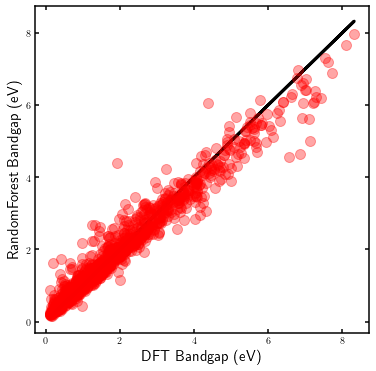

In [138]:
import matplotlib.pyplot as plt

Y_pred = best.predict(X)

plt.subplots(figsize=(6, 6))

plt.plot(Y, Y, "k", lw=3)
plt.plot(Y, Y_pred, "ro", ms=10, alpha=0.35)
plt.xlabel("DFT Bandgap (eV)", fontsize=15)
plt.ylabel("RandomForest Bandgap (eV)", fontsize=15)

plt.show()

